<b><font size=20, color='#A020F0'>Precipitation Analysis

Mitchell Zotter<br>
12/13/23<br>

#### <span style="color:green">Learning Goals</span>
By the end of this project you will
1. Understand how to calculate climatologies and anomalies of precipitation
2. Practice reading in netcdf files and doing computations on xarray datasets
3. Use this project as a template for larger datasets
4. Utilize GPCP data and relate it to ENSO conditions

#### Resources (Predominately for Xarray)
[Xarray Documentation](http://xarray.pydata.org/en/stable/)<br>
[Xarray API reference](http://xarray.pydata.org/en/stable/api.html)<br>

# Background

A focal point of coding in meteorology and atmospheric sciences is the process of computing and visualizing climatology periods and calculating anomalies in data. This past summer, I had a virtual internship at the North Carolina Institute for Climate Studies (NCICS) in Asheville, North Carolina. I was tasked with using Python to help calculate climatologies and anomalies for the Leaf Area Index, which, as stated by the [NCEI](https://www.ncei.noaa.gov/products/climate-data-records/leaf-area-index-and-fapar), is "the one-sided green leaf area per unit of ground surface area". I used packages such as numpy, matplotlib, and most predominantly, xarray.

However, the [netCDF files](https://www.ncei.noaa.gov/data/avhrr-land-leaf-area-index-and-fapar/access/2000/) that have LAI data for each date are in the milibytes, and as such need a large jupyter environment to be usable without risking your disk filling up. So, in this project, I will be showing you the process that I learned from my work at the NCICS using a much more manageable dataset, the [GPCP](https://www.ncei.noaa.gov/products/global-precipitation-climatology-project), which provides daily, pentad, and monthly precipitation data for the entire globe since 1979 (1997 for daily only). After we conclude the tutorial, we will do a real example for a question that I have.

Before we begin, let us import some of our needed packages.

In [412]:
#Import packages.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import pandas as pd
from datetime import datetime as dt
import xarray as xr

---

# Tutorial

## 1. Downloading your datasets from the NCEI database.

#### 1.1 Download the 1997 - 2007 GPCP Files 
What is a dataset without any netCDF files?

Getting your data is essential for any Python project. So, we will do it together. For this example, we will download the GPCP data

Open up a terminal in the gpcp_data folder (or whatever you decide to call it) and copy this line over to the terminal.

    wget -r -np -nH --cut-dirs 3 -A '*.nc' https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/

<b><font color='red'>IMPORTANT:</font></b> <b>After /access/, type the year of your choosing and add a / after the year before you execute the command. If you don't, you will download every year of the GPCP data at once!</b>

While the data is downloading for each year, we will continue ahead with making our code. Put your yearly data into your daily_precip (or whatever you decide to call it) folder.

#### 1.2 Open a dataset

The nice thing with NCEI data is that you do not need to manually make a dataset.

In [344]:
#Define your dataset
ds = xr.open_mfdataset('/daily_precip/*/*.nc', parallel=True)
ds

<xarray.Dataset>
Dimensions:      (latitude: 180, longitude: 360, time: 4017, nv: 2)
Coordinates:
  * latitude     (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * longitude    (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * time         (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2007-12-31
Dimensions without coordinates: nv
Data variables:
    lat_bounds   (time, latitude, nv) float32 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    lon_bounds   (time, longitude, nv) float32 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip       (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/199701/s...
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) 2017-05-30T16:53:52Z, Dr. Jian-Jian Wang, ...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:XXXXX
    product_version:            v01r03
    platform:                   GOES (Geostationary Operational Environmental...
    sensor:                     Imager, TOVS > TIROS Operational Vertical Sou...
    spatial_resolution:         1 degree
    comment:                    Processing computer: eagle2.umd.edu

To just get the precipitation data, type `ds.precip`. This will show you how large the precipitation data is.

In [201]:
#Look at the precipitation data
ds.precip

<xarray.DataArray 'precip' (time: 4017, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(4017, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2007-12-31
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of Daily GPCP Satellite-Ga...
    standard_name:  lwe_precipitation_rate
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

---

## 2. The nitty-gritty.

#### 2.1 Creating your monthly averages.

Creating your monthly averages will help facilitate the process of making climatologies and anomalies later down the road.

In [ ]:
#Create path and loop for five year periods at a time so you do not overload the kernel
path = '/daily_precip/*'
new_path = '/monthly_avg/'

In [138]:
year = np.arange(2002, 2007) #This will read from 1997 to 2001. 2002 is used as a buffer. #Do the same for 2002-2007
#Create a for loop for monthly averages
for i in year:
    # step 1: get the list of files of all daily files within each year 
    dir = path + str(i)
    # step 2: open all daily files within a year
    ds = xr.open_mfdataset(dir + '/*.nc', parallel=True)
    # step 3: set your precip variable to ds.precip
    precip = ds.precip
    # step 4: following the steps that you have doing the masking, calculate monthly average
    monthly_avg = precip.resample(time="1MS", skipna=True).mean()
    monthly_avg.to_netcdf(new_path + str(i) + "_monthly_avg.nc")

#### 2.2 Creating climatologies.

To create your climatologies, you must make a path that will allow xarray to open your monthly average files. In addition, make a new path that will direct your new files to the climatology folder.

In [348]:
#Create for loop for climatology
path = '/monthly_avg/'
new_path = '/climatology_mean/'

In [ ]:
#Open all daily files within a year
ds = xr.open_mfdataset(path + '*_monthly_avg.nc', concat_dim = 'time', combine = 'nested', parallel=True)

Use `time=slice()` to list what dates you want to use for your climatology file. Make sure you list `"time.month"` in the groupby section.

In [62]:
#Make your netCDF files for 1997-2001.
ds_5yr1 = ds.precip.sel(time=slice("1997-01-01", "2001-12-01"))
dsclim_5_1 = ds_5yr1.groupby("time.month").mean(dim="time", skipna=True)
dsclim_5_1.to_netcdf(new_path + '1997-2001_climatology_mean.nc')

In [63]:
#Repeat for 2002-2006.
ds_5yr2 = ds.precip.sel(time=slice("2002-01-01", "2006-12-01"))
dsclim_5_2 = ds_5yr2.groupby("time.month").mean(dim="time", skipna=True)
dsclim_5_2.to_netcdf(new_path + '2002-2006_climatology_mean.nc')

In [346]:
#Repeat for 1997-2006.
ds_10yr = ds.precip.sel(time=slice("1997-01-01", "2006-12-01"))
dsclim_10 = ds_10yr.groupby("time.month").mean(dim="time", skipna=True)
dsclim_10.to_netcdf(new_path + '1997-2006_climatology_mean.nc')

#### 2.3 Creating anomalies.

The process for creating anomalies is similar to that of climatologies, but you must have your path be directed to your climatology and your new path directed to your anomalies folder.

In [350]:
#Step 1: Copy your dataset from 2.2
ds = xr.open_mfdataset(path + '*_monthly_avg.nc', concat_dim = 'time', combine = 'nested', parallel=True)

In [ ]:
#Step 2: Make paths to your climatology and anomalies
path = '/climatology_mean/'
new_path = '/anomalies/'

In [351]:
#Step 3: Define your climatology variable.
precip_clim = xr.open_mfdataset(path + '1997-2006_climatology_mean.nc', parallel=True)

#Step 4: Create a for loop for monthly averages
year = np.arange(1997,2007)
for i in year:
    ds_1yr = ds.precip.sel(time=slice(str(i) + '-01-01', str(i) + '-12-01'))
    ds_1yranom = ds_1yr.groupby("time.month").mean(dim="time", skipna=True)
    precip_anom = ds_1yranom - precip_clim
    precip_anom.to_netcdf(new_path + str(i) + "_anomaly.nc")

Now that we have our climatology and anomaly netCDFs, we will proceed to make some figures.

---

## 3. Creating your figures.

#### 3.1 Setting your paths.

Before you create your figures, you must define your variables; one for climatology and one for anomalies.

In [113]:
#Create your paths to your climatology variable
path1 = '/climatology_mean/'
path2 = '/anomalies/'

#### 3.2 Creating your climatology figure

Follow the directions carefully down below. The region of the globe we will be focusing on specifically is the tropics, so set your axis extent to `[-180, 180, -30, 30]`.

In [123]:
#Define your climatology variable
precip_clim = xr.open_mfdataset(path1 + '1997-2006_climatology_mean.nc', parallel=True)

# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(
    nrows=2, ncols=2, subplot_kw={"projection": ccrs.Robinson()}, figsize=(12,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()
plt.tight_layout(pad=4)
plt.suptitle('1997-2006 GPCP Climatology')
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Loop over selected months (Jan, Apr, Jul, Oct)
for i, month in enumerate([1, 4, 7, 10]):

    # Draw the coastines and major gridline for each subplot. We will solely be focusing on the tropics.
    axs[i].coastlines()
    axs[i].gridlines()
    axs[i].set_extent([-180,180,-30,30],ccrs.PlateCarree())

    # Draw the precipitation data
    precip_clim.precip.sel(month=month).plot(
         ax=axs[i],
         transform=ccrs.PlateCarree(),
         vmin=0,
         vmax=10,  # use the same range of max and min value
         cmap=mpl.cm.YlGn,
         cbar_kwargs=dict(shrink=0.5, label="GPCP\n(mm/month)"),
     )

#### 3.3 Creating anomalies.

Follow the directions carefully down below. Instructions are similar to climatology. To really get a sense as to what the anomaly difference is like from the end of a period to the beginning, take the difference. Or, if you just want to compare one year to the 10-year climatology, just read in your desired anomaly file.

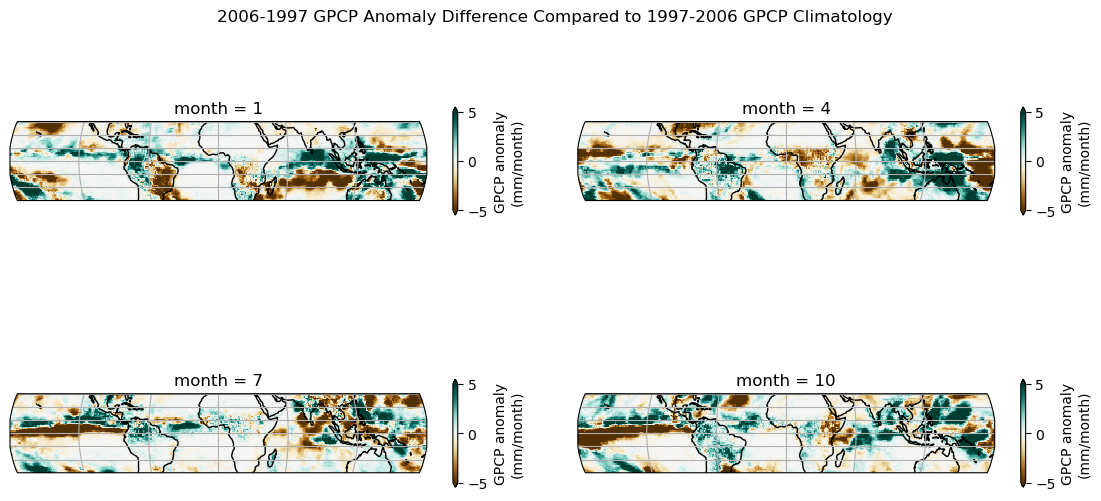

In [359]:
#Define your anomaly variable
anom2006 = xr.open_dataset(path2 + '2006_anomaly.nc')
anom1997 = xr.open_dataset(path2 + '1997_anomaly.nc')
precip_anom = anom2006 - anom1997

# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(
    nrows=2, ncols=2, subplot_kw={"projection": ccrs.Robinson()}, figsize=(12, 6)
)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()
plt.tight_layout(pad=4)
plt.suptitle('2006-1997 GPCP Anomaly Difference Compared to 1997-2006 GPCP Climatology')
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Loop over selected months (Jan, Apr, Jul, Oct)
for i, month in enumerate([1, 4, 7, 10]):

    # Draw the coastines and major gridline for each subplot. We will solely be focusing on the tropics.
    axs[i].coastlines()
    axs[i].gridlines()
    axs[i].set_extent([-180,180,-30,30],ccrs.PlateCarree())

    # Draw the precipitation data
    precip_anom.precip.sel(month=month).plot(
         ax=axs[i],
         transform=ccrs.PlateCarree(),
         vmin=-5,
         vmax=5,  # use the same range of max and min value
         cmap=mpl.cm.BrBG,
         cbar_kwargs=dict(shrink=0.5, label="GPCP anomaly\n(mm/month)"),
     )

With that, our tutorial is complete. This process of computing climatology and anomalies can also be used with larger datasets such as the Leaf Area Index. 

Now, we will dive into a question that I have had for a while now.

---

# Precipitation and ENSO

Every scientist in the field of atmospheric science has heard of the El Niño Southern Oscillation, or ENSO, before. But for those who are just entering the field, this is the [National Weather Service's](https://www.weather.gov/mhx/ensowhat) definition: 

"The El Niño-Southern Oscillation (ENSO) is a recurring climate pattern involving changes in the temperature of waters in the central and eastern tropical Pacific Ocean. On periods ranging from about three to seven years, the surface waters across a large swath of the tropical Pacific Ocean warm or cool by anywhere from 1°C to 3°C, compared to normal.

This oscillating warming and cooling pattern, referred to as the ENSO cycle, directly affects rainfall distribution in the tropics and can have a strong influence on weather across the United States and other parts of the world. El Niño and La Niña are the extreme phases of the ENSO cycle; between these two phases is a third phase called ENSO-neutral".

El Niño is the warm phase of ENSO, while La Niña is the cool phase of ENSO. Which brings me to my question: how does precipitation vary with ENSO?

---

## 4. El Niño and La Niña.

<img src='oni1990.png' width=1200></img>

This figure from the [Golden Gate Weather Service](https://ggweather.com/enso/oni.htm) shows the Oceanic Niño Index (ONI) from 1990 to present. From 1997-2006, the period of interest was defined by a very strong El Niño from 1997-1998, before plunging to a persistent La Niña until 2002. The ONI varied through the end of our GPCP period, being mostly relegated within the confines of the ENSO-neutral boundaries.

Our task is to determine the precipitation conditions every month in the Eastern Equatorial Pacific from 1997-2006, and deduce from the figures we create what precipitation anomalies correlate with certain ENSO phases.

#### 4.1 Make figures of the Eastern Equatorial Pacific Ocean Anomalies.

For this, you will need to read in your anomaly varibale from step 3.3 and set it to what year you want to read in. Make sure the title relfects the year. Also, set the maximum latitude boundary to `-60` so that you will see the coastline of South America. Let's do 1998's data, as there was a strong El Niño at the start of the year continuing from late 1997.

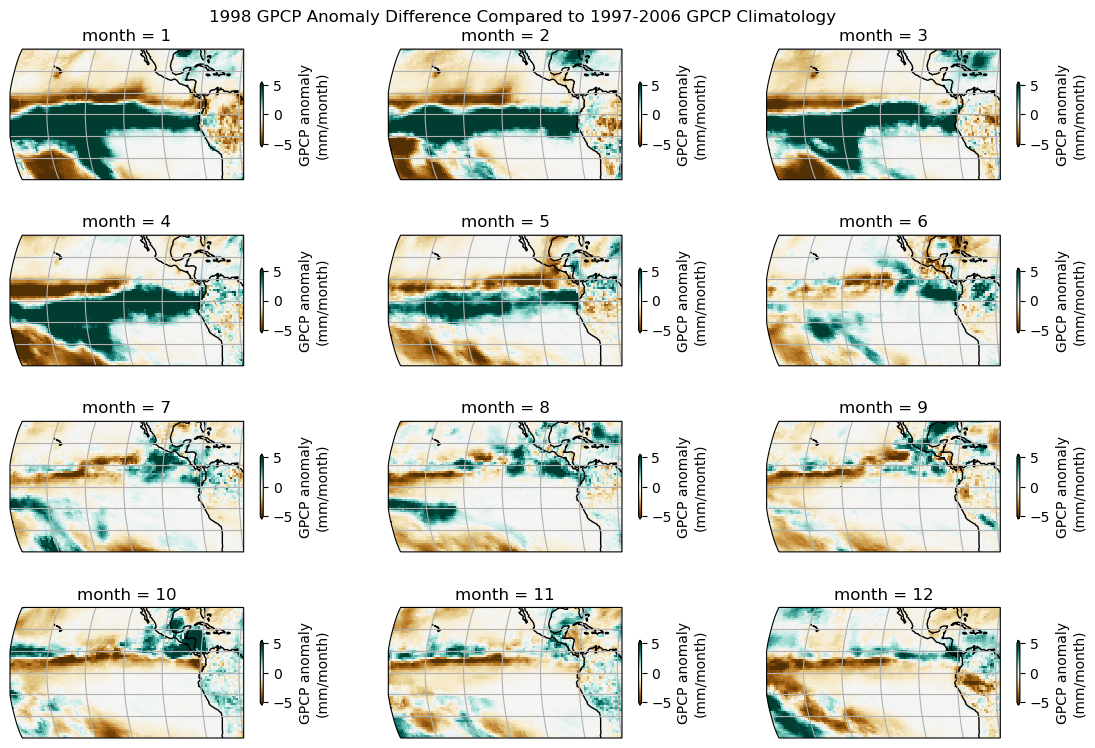

In [409]:
# Read your data in
precip_anom = xr.open_dataset(path2 + '1998_anomaly.nc')

# define the figure and each axis for the 3 rows and 4 columns
fig, axs = plt.subplots(
    nrows=4, ncols=3, subplot_kw={"projection": ccrs.Robinson()}, figsize=(12, 8)
)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()
plt.tight_layout(pad=4)
plt.suptitle('1998 GPCP Anomaly Difference Compared to 1997-2006 GPCP Climatology')
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Loop over all months of the year
for i, month in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):

    # Draw the coastines and major gridline for each subplot. We will solely be focusing on the tropics.
    axs[i].set_title(month_list[i])
    axs[i].coastlines()
    axs[i].gridlines()
    axs[i].set_extent([-180,-60,-30,30],ccrs.PlateCarree())
    
    # Draw the precipitation data
    precip_anom.precip.sel(month=month).plot(
         ax=axs[i],
         transform=ccrs.PlateCarree(),
         vmin=-5,
         vmax=5,  # use the same range of max and min value
         cmap=mpl.cm.BrBG,
         cbar_kwargs=dict(shrink=0.5, label="GPCP anomaly\n(mm/month)"),
     )

<b><font color='black'>NOTE:</font></b> It is a good idea to save these figures to a folder on your desktop, and upload them to a separate folder in your jupyter environment for reference.

#### 4.2 Manipulation

The best way to show how precipitation changes by month with each year with any given coordinate is to plot our data on a bar graph. But before we make our bar graph, we must take the mean across a range of latitude and longitudes.

Use `latitude=slice()` and `longitude=slice()` to set your boundaries. Make sure that your max value is one more than the right latitude boundary you want to get.

In [ ]:
#Create your paths to your anomaly netCDF
path = '/anomalies/'

In [ ]:
#Make a precipitation anomaly variable averaged over a range of latitude and longitude.
precip_anom = xr.open_mfdataset(path + '*_anomaly.nc', concat_dim='time', combine='nested', parallel=True)
precip_anom_bar = precip_anom.precip.sel(latitude=slice(-30,31), longitude=slice(0,61)).mean(dim=('latitude', 'longitude'))

#### 4.3 Monthly plotting

Much like 4.1, we will be plotting with 12 figures. Instead of using xarray's built-in plotting, we will use matplotlib's bar plotting function, as xarray does not do well with bar graphs.

The solid lines denote where precipitation is 0.5 mm above or below normal, indicating a very strong ENSO event, while the dashed lines indicate precipitation anomalies 0.25 mm above or below normal, indicating a moderate ENSO event.

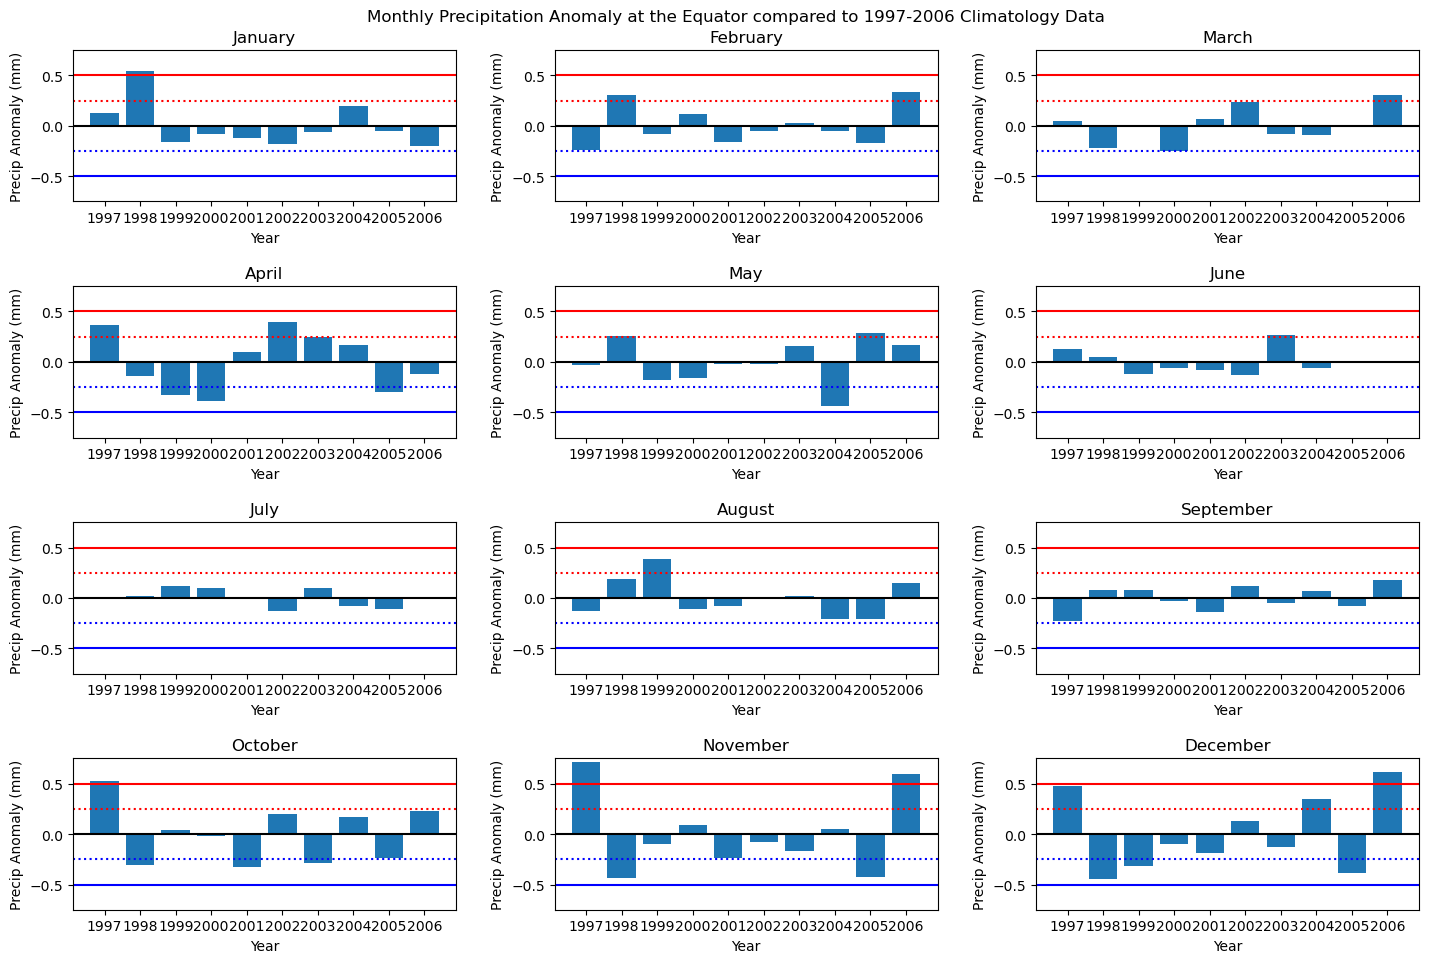

In [413]:
# define the figure and each axis for the 3 rows and 4 columns
fig, axs = plt.subplots(
    nrows=4, ncols=3, figsize=(15, 10)
)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()
plt.tight_layout(pad=4)
plt.suptitle('Monthly Precipitation Anomaly at the Equator compared to 1997-2006 Climatology Data')
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Loop over all months of the year
for i, month in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):

    # Draw the precipitation data
    axs[i].bar(precip_anom_bar.time, precip_anom_bar.sel(month=month))
    axs[i].set_ylim(-0.75,0.75)
    axs[i].axhline(y=0, color='k')
    axs[i].axhline(y=0.5, color='r')
    axs[i].axhline(y=-0.5, color='b')
    axs[i].axhline(y=0.25, color='r', linestyle='dotted')
    axs[i].axhline(y=-0.25, color='b', linestyle='dotted')
    axs[i].set_title(month_list[i])
    axs[i].set_xlabel('Year')
    axs[i].set_xticks(np.arange(0,10,1))
    axs[i].set_xticklabels(['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006'])
    axs[i].set_ylabel('Precip Anomaly (mm)')

As we can see from this figure, based on the ONI index image in 4.1, the months that had precipitation anomalies above 0.25 mm per year means wetter than normal conditions at the Equator. Because wetter than normal conditions are synonymous with warmer weather, this means that thse months correlate with an El Niño. And vice-versa, the months that had precipitation anomalies below 0.25 mm per year means drier than normal conditions at the Equator. Drier than normal conditions are synonymous with cooler weather, which correlates with a La Niña. Months that were between -0.25 and 0.25 mm per year are in the ENSO-neutral range.

In short, wetter than normal conditions at the Equator usually correlate with El Niño, and drier than normal conditions at the Equator usually correlate with La Niña.

---

# Conclusion

This concludes my presentation into analyzing precipitation using NOAA's GPCP datasets. The GPCP data I used in this project is small compared to the data I originally intended to use, but my investigation into GPCP in correlation with ENSO is only one example of the usages of NOAA's NCEI data. I hope you will find this notebook useful for analyzing other, larger sets of data, like the Leaf Area Index, on a jupyter notebook that can handle the size of larger netCDFs from NOAA.

Thank you for using!

---